<a href="https://colab.research.google.com/github/Taeyoungleee/ComputerVision_Seminar/blob/main/practice/CV_seminar_week4_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pwd

'/content'

In [ ]:
%cd /content/drive/MyDrive/CV_seminar_project

/content/drive/MyDrive/CV_seminar_project


In [ ]:
import torch
import torchvision
from torchvision import transforms # 이미지 데이터 augmentation
import os
import glob

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42)
if device == 'cuda':
  torch.cuda.manual_seed_all(42)

In [ ]:
device

'cuda'

In [ ]:
root_path = '/content/drive/MyDrive/CV_seminar_project'
train_path = '/content/drive/MyDrive/CV_seminar_project/train'
test_path = '/content/drive/MyDrive/CV_seminar_project/test'

# pytorch 데이터셋 클래스 실습

### 1. 파이토치 데이터 셋 클래스를 직접 만들어보자.

파이토치 데이터 셋 클래스는 init, getitem, len 특수 메소드 3개를 요구한다.   
 항상 같은 포맷을 만드는 습관이 중요하다. 
> 따라서 root_path, mode(train or validation or test), transform(전처리&Augmentation) 3개의 입력을 받아 data와 label을 출력하는 클래스를 만들도록하자.


In [ ]:
from torch.utils.data import Dataset, DataLoader
import cv2
import os 

class Custom_dataset(Dataset):
  def __init__(self, root_path, mode, transforms=None):
    self.all_data = sorted( glob.glob( os.path.join(root_path, mode, '*', '*') ) ) # 전체 경로
    self.transforms = transforms

  def __getitem__(self, index):
    if torch.is_tensor(index): # 인덱스가 tensor형태일 수 있는 것을 방지
      index = index.tolist()

    data_path = self.all_data[index] # 인덱스가 부여된 데이터 1개
    image = cv2.imread(data_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # cv2 라이브러리의 BGR 형식을 RGB로 permute

    # transfrom 적용
    if self.transforms is not None:
      augmentation = self.transforms(image = image)
      image = augmentation['image']

    # 이미지의 이름을 이용하여, label 부여하기
    if 'dolphin' in data_path:
      label = 0
    elif 'shark' in data_path:
      label = 1
    else:
      label = 2

    return image, label

  def __len__(self):
    length = len(self.all_data)
    return length

### 2. 전처리와 Augmentation을 적용한다.
> Normalize: 픽셀 값에 대해 (X - mean)/std를 진행하며, 이때 통계 값은 ImageNet 데이터 셋의 RGB 통계값을 이용할 것이다.
>   
> 텐서화: 파이토치는 tensor자료 형을 이용하므로 totensor를 해준다.   
>   
> augmentation: trainset에만 적용한다.


In [ ]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2 # albumentations 텐서화 함수

train_transforms = A.Compose([
    A.Resize(224,224),
    A.RandomCrop(200,200),
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.7),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.HueSaturationValue(hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-20, 20), p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.3,0.3), contrast_limit=(-0.3, 0.3), p=0.5),
    A.ChannelShuffle(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 이미지넷 데이터셋 통계값으로 Normalize
    ToTensorV2()
])

test_transforms = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 텐서타입은 안해줌
    ToTensorV2() # Normalize를 먼저하고 tensor화를 진행해야한다.
])

### Pytorch 데이터 클래스 생성
train_class = Custom_dataset(root_path=root_path, mode='train', transforms=train_transforms)
valid_class = Custom_dataset(root_path=root_path, mode='valid', transforms=test_transforms)
test_class = Custom_dataset(root_path=root_path, mode='test', transforms=test_transforms)

### Pytorch BatchLoader 생성 (학습에 이용할 최종 dataloader)
from torch.utils.data import DataLoader as DataLoader

train_loader = DataLoader(train_class, batch_size=8, shuffle = True, num_workers=0)
valid_loader = DataLoader(valid_class, batch_size=8, shuffle = False, num_workers=0)
test_loader = DataLoader(test_class, batch_size=8, shuffle = False, num_workers=0)

In [ ]:
from PIL import Image as PILImage
from google.colab.patches import cv2_imshow
import numpy as np

In [ ]:
train_1 = train_class[0][0]
train_1 = train_1.permute((1, 2, 0))

In [ ]:
train_1.shape

torch.Size([200, 200, 3])

In [ ]:
mean, std = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])

In [ ]:
train_1 = np.clip(255.0 * (train_1 * std + mean), 0, 255) # Unnormalization
train_1 = np.array(train_1, dtype=int)
train_1 # 모양 확인

array([[[  8,  81, 103],
        [  6,  81, 103],
        [  0,  77,  99],
        ...,
        [ 19, 106, 165],
        [ 21, 107, 165],
        [ 22, 108, 167]],

       [[  4,  79, 101],
        [  4,  80, 103],
        [  0,  77,  99],
        ...,
        [ 19, 106, 165],
        [ 22, 108, 167],
        [ 22, 108, 167]],

       [[  0,  78, 100],
        [  2,  81, 104],
        [  0,  80, 103],
        ...,
        [ 18, 105, 164],
        [ 19, 106, 165],
        [ 22, 108, 167]],

       ...,

       [[  9,  26,  48],
        [ 10,  26,  47],
        [  9,  25,  45],
        ...,
        [ 61, 127, 173],
        [ 58, 125, 173],
        [ 56, 123, 173]],

       [[  4,  25,  44],
        [  6,  27,  46],
        [  8,  26,  45],
        ...,
        [ 60, 125, 173],
        [ 56, 123, 173],
        [ 56, 123, 174]],

       [[  2,  25,  41],
        [  4,  28,  45],
        [  6,  31,  45],
        ...,
        [ 58, 125, 173],
        [ 56, 123, 173],
        [ 56, 124, 176]]

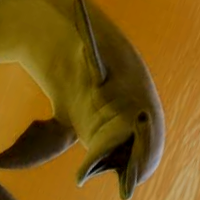

In [ ]:
cv2_imshow(train_1)

# week4 과제
아래와 같이 원래 0~255 픽셀 값을 가진 귀여운 돌고래 이미지는 Augmentation이 적용되어(train_class[0][0]) 이미지가 변형 되었다.   
**train_class[0][0] 데이터**를 시각화 할 수 있도록 시각화 라이브러리가 요구하는 numpy 타입의 올바른 이미지 데이터로 되돌리는 역함수를 만들어 시각화 해오는 것.   

결과물에 대해서는 week4 pdf의 과제 설명에 있는 이미지를 보시면 이해될 것입니다.

In [ ]:
train_class.all_data[0]

'/content/drive/MyDrive/CV_seminar_project/train/dolphin/dolphin_000.jpg'

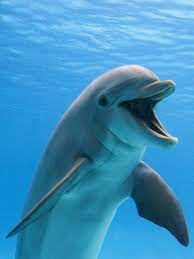

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image as PILImage
PILImage.open(train_class.all_data[0])

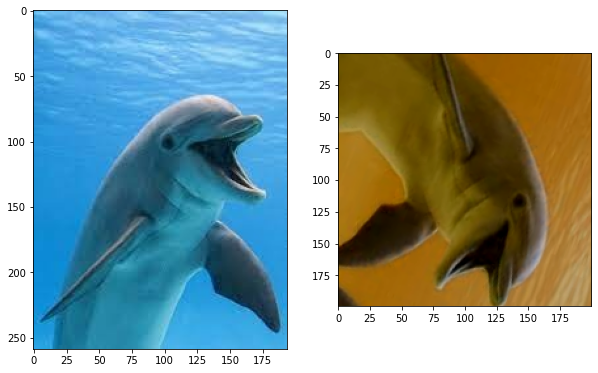

In [ ]:
plt.figure(figsize=(10,10))
img = cv2.imread(train_class.all_data[0])

# fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img[:,:,::-1])
plt.subplot(1,2,2)
plt.imshow(train_1[:,:,::-1])

# 더 좋은 코드

In [ ]:
train_class[0][0] # 역함수를 이용해 이것을 시각화 해주세요.

tensor([[[-1.0048, -0.9705, -0.9877,  ..., -0.3712, -0.3712, -0.3712],
         [-1.0733, -1.0562, -1.0562,  ..., -0.2684, -0.2856, -0.2684],
         [-1.1075, -1.1075, -1.1075,  ..., -0.3027, -0.2856, -0.2856],
         ...,
         [-1.5185, -1.5185, -1.5185,  ..., -1.2103, -1.2617, -1.2617],
         [-1.5357, -1.5357, -1.5185,  ..., -1.1589, -1.2103, -1.2103],
         [-1.5528, -1.5357, -1.5185,  ..., -1.1075, -1.1589, -1.1247]],

        [[ 1.2206,  1.2556,  1.3256,  ...,  1.5357,  1.4657,  1.4657],
         [ 1.1506,  1.1681,  1.1506,  ...,  1.5182,  1.5182,  1.5182],
         [ 1.1506,  1.1331,  1.1155,  ...,  1.5182,  1.5182,  1.5182],
         ...,
         [ 0.5028,  0.5028,  0.5028,  ...,  1.3957,  1.4307,  1.4307],
         [ 0.5028,  0.5028,  0.4853,  ...,  1.3081,  1.3431,  1.3431],
         [ 0.4853,  0.4853,  0.4853,  ...,  1.2556,  1.2731,  1.2731]],

        [[ 1.8731,  1.9080,  1.8731,  ...,  2.0125,  2.0125,  2.0125],
         [ 1.8034,  1.8208,  1.8034,  ...,  2

In [ ]:
def converter(augmentationed_image):
  mean=(0.485, 0.456, 0.406)
  std=(0.229, 0.224, 0.225)


  ### 역함수 로직을 짜주세요. ###
  augmentationed_image = augmentationed_image.permute(2,1,0) # 채널축 정상적으로 맨뒤로 보내기
  augmentationed_image = augmentationed_image.numpy() # numpy 타입으로 변환
  augmentationed_image = (augmentationed_image * std) + mean # Unnormalize
  converted_image = augmentationed_image * 255 # Unscailing
  converted_image = converted_image.astype(int)


  return converted_image

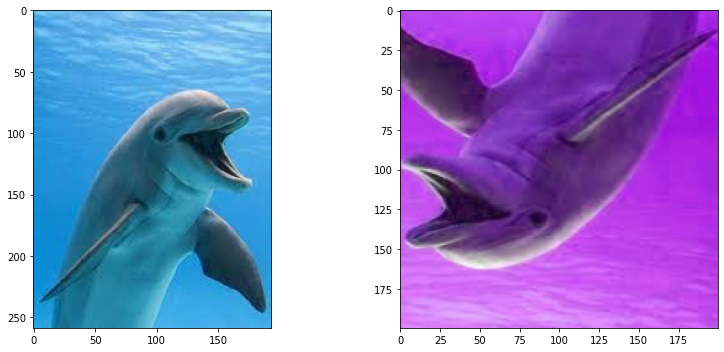

In [ ]:
import matplotlib.pyplot as plt
converted_image = converter(train_class[0][0])

plt.figure(figsize = (12,5))

plt.subplot(1, 2, 1) 
raw_image = plt.imread(train_class.all_data[0])
plt.imshow(raw_image)

plt.subplot(1, 2, 2) 
plt.imshow(converted_image)

plt.tight_layout()